# DepMap WGS and WES variant filtering and whitelisting evaluation



# Outline

- [Setup](#setup)
   - [Dependencies](#load-packages)
- [Sanity checks of variants](#sanity-checks)
- [CompareToPastRelease]()

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%capture
!pip install plotly

## Load packages

In [3]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from taigapy import TaigaClient
tc = TaigaClient()

In [4]:
%pwd

'/home/ubuntu/depmap_dnaeval/mutations'

## Load Datasets

In [5]:
%%capture

maf_variants_23q4 = pd.read_table("/home/ubuntu/depmap_dnaeval/23Q4_maf/23Q4_mutation_maf_latest.tsv")
## maf_variants = pd.read_table("23Q4_mutation_maf_old.tsv", sep='\t')

release_maf_23q2 = tc.get(name='internal-23q2-1e49', version=98, file='OmicsSomaticMutations')
release_standard_maf = tc.download_to_cache(name='internal-23q2-1e49', version=98, file='OmicsSomaticMutationsMAFProfile.maf')  # download_to_cache for raw
release_standard_maf_23q2 = pd.read_table(release_standard_maf)

In [6]:
# past_release_standard_maf is profile-based
# past_release_maf is model-based

# Sanity checks

## Sanity checks for compound variants that has multiple consequences even with --pick

- Typical examples are splicing variants that may be missense mutation as well

In [7]:
check_columns = ['pos', 'gnomadg_af', 'hess_driver', 'vep_impact', 'cosmic_tier', 'civic_score', 'clnsig', 'hugo_symbol', 'vep_mane_select', 'variant_info', 'protein_change', 'oncokb_oncogenic', 'oncokb_effect', 'oncokb_hotspot', 'rescue']

In [8]:
# splicing mutation do not have protein changes
# when co-exist with synonymous mutation or missense mutation
# there will be protein changes
maf_variants_23q4.query("variant_info.str.contains('&')")[check_columns]

pos  gnomadg_af hess_driver vep_impact  cosmic_tier  \
35        46185307         NaN         NaN   MODERATE          NaN   
234       47406045         NaN         NaN   MODERATE          NaN   
275      149520808      0.1012         NaN       HIGH          NaN   
276      151416314         NaN         NaN   MODERATE          NaN   
325      114829792         NaN         NaN       HIGH          NaN   
...            ...         ...         ...        ...          ...   
1124118   13006331         NaN         NaN       HIGH          NaN   
1124128  128261561         NaN         NaN   MODERATE          NaN   
1124156   19265849         NaN         NaN   MODERATE          NaN   
1124185    3483592         NaN         NaN   MODERATE          NaN   
1124212   41357831      0.4546         NaN       HIGH          NaN   

         civic_score      clnsig hugo_symbol vep_mane_select  \
35               NaN         NaN      TSPAN1     NM_005727.4   
234              NaN         NaN      PTPN23     NM_015466.4   
275              NaN         NaN       WWTR1     NM_015472.6   
276              NaN         NaN      MED12L  NM_001393769.1   
325              NaN         NaN       NDST4     NM_022569.3   
...              ...         ...         ...             ...   
1124118          NaN         NaN      TRMT9B     NM_020844.3   
1124128          NaN         NaN      GOLGA2  NM_001366244.2   
1124156          NaN         NaN     PLEKHA5  NM_001256470.2   
1124185          NaN  Pathogenic        ASPA     NM_000049.4   
1124212          NaN         NaN       DDX3X             NaN   

                                              variant_info  \
35                  missense_variant&splice_region_variant   
234                 missense_variant&splice_region_variant   
275                         stop_gained&frameshift_variant   
276                 missense_variant&splice_region_variant   
325                      stop_gained&splice_region_variant   
...                                                    ...   
1124118  splice_donor_variant&splice_donor_region_varia...   
1124128             missense_variant&splice_region_variant   
1124156             missense_variant&splice_region_variant   
1124185             missense_variant&splice_region_variant   
1124212     splice_acceptor_variant&NMD_transcript_variant   

                         protein_change oncokb_oncogenic oncokb_effect  \
35        ENSP00000361072.1:p.Glu226Gly              NaN           NaN   
234       ENSP00000265562.4:p.Leu182Pro              NaN           NaN   
275         ENSP00000353847.3:p.Ter401=              NaN           NaN   
276      ENSP00000508695.1:p.Met2100Ile              NaN           NaN   
325       ENSP00000264363.2:p.Glu833Ter              NaN           NaN   
...                                 ...              ...           ...   
1124118                             NaN              NaN           NaN   
1124128   ENSP00000478799.2:p.Val409Ile              NaN           NaN   
1124156   ENSP00000404296.2:p.Lys237Thr              NaN           NaN   
1124185   ENSP00000263080.2:p.Gly176Ser              NaN           NaN   
1124212                             NaN              NaN           NaN   

        oncokb_hotspot  rescue  
35                 NaN   False  
234                NaN   False  
275                NaN    True  
276                NaN   False  
325                NaN   False  
...                ...     ...  
1124118            NaN   False  
1124128            NaN   False  
1124156            NaN   False  
1124185            NaN   False  
1124212            NaN    True  

[42831 rows x 15 columns]

In [9]:
# Remaining compound synonymous mutations are caused by rescue
# 25 of them are from julian's papers
maf_variants_23q4.query("variant_info.str.contains('&') & variant_info.str.contains('syno')").value_counts("hess_driver"), maf_variants_23q4.query("variant_info.str.contains('&') & variant_info.str.contains('syno')").value_counts("rescue").sum()

(hess_driver
 Y    25
 dtype: int64,
 71)

In [10]:
# No missense and Synonymous mutation co-occur
# This is a sanity check that we chose only one transcript per variant
((maf_variants_23q4.variant_info.str.contains('synony')) & (maf_variants_23q4.variant_info.str.contains('mis'))).sum()

0

<Axes: xlabel='gnomadg_af', ylabel='Count'>

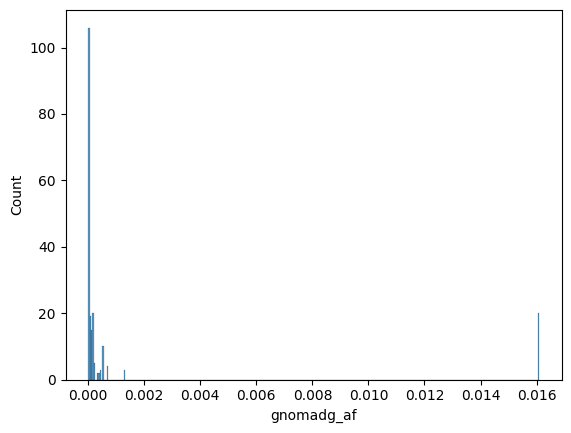

In [11]:
# We will not keep low frequency synonymous mutation that are never compound with splicing or other consequences
sns.histplot(maf_variants_23q4.query("variant_info.str.contains('syno')")['gnomadg_af'])

## Sanity checks of repeat elements

In [12]:
# Some segmental duplicates are masking the oncokb annotations
# but rescued back
maf_variants_23q4.query("segdup == 'Y'").shape, maf_variants_23q4.query("segdup == 'Y'").value_counts('oncokb_effect')

((161, 83),
 oncokb_effect
 Gain-of-function           103
 Likely Loss-of-function     26
 Likely Gain-of-function      8
 Inconclusive                 1
 dtype: int64)

In [13]:
# all of the repeat masking variants are from high impact variants on Tumor Suppressor or Oncogene
# We only whitelisting high impact mutations that locate in the Tumor Suppressor or Oncogene
maf_variants_23q4.query("rm == 'Y'").shape, maf_variants_23q4.query("rm == 'Y'").value_counts('vep_impact')

((35, 83),
 vep_impact
 HIGH    35
 dtype: int64)

## Sanity checks of several mutations in St Jude clinical pipeline

In [14]:
maf_variants_23q4.loc[maf_variants_23q4.pos == 105272633, ['hugo_symbol', 'vep_impact']]

hugo_symbol vep_impact
741413         TET2       HIGH
1085219        TET2       HIGH

In [15]:
maf_variants_23q4.loc[maf_variants_23q4.pos == 41224921, ['hugo_symbol', 'vep_impact']]

hugo_symbol vep_impact
741539        USP9X       HIGH
1085374       USP9X       HIGH

In [16]:
maf_variants_23q4.loc[maf_variants_23q4.pos == 124064037, ['hugo_symbol', 'vep_impact']]

hugo_symbol vep_impact
757255        STAG2       HIGH
1034840       STAG2       HIGH

In [17]:
maf_variants_23q4.loc[maf_variants_23q4.pos == 48791112, ['hugo_symbol', 'vep_impact']]


hugo_symbol vep_impact
414528        GATA1       HIGH
607806        GATA1       HIGH
1110274       GATA1       HIGH

In [18]:
# Miss two only St Jude InDel now

## SJSA1	chr12.49041176.G.	chr12.49041180.GGAT.GTT	InDel
## SKNAS	chr6.156778971..GCA	chr6.156778980.GG.GCAGG	InDel
maf_variants_23q4.loc[maf_variants_23q4.pos.isin(np.array([23803335, 7675067, 47355346, 68293321, 156778971, 226064457, 49041176]) - 1), check_columns]

pos  gnomadg_af hess_driver vep_impact  cosmic_tier  \
42149     23803334         NaN         NaN       HIGH          NaN   
69805     49041175         NaN         NaN       HIGH          NaN   
135669    23803334         NaN         NaN       HIGH          NaN   
153261    68293320         NaN         NaN   MODERATE          NaN   
252458     7675066         NaN         NaN       HIGH          NaN   
377942   226064456         NaN         NaN   MODERATE          NaN   
599019    49041175         NaN         NaN       HIGH          NaN   
743321    23803334         NaN         NaN       HIGH          NaN   
897521    49041175         NaN         NaN       HIGH          NaN   
955770    23803334         NaN         NaN       HIGH          NaN   
1000443  226064456         NaN         NaN   MODERATE          NaN   
1072895   68293320         NaN         NaN   MODERATE          NaN   
1105087    7675066         NaN         NaN       HIGH          NaN   
1117619   68293320         NaN         NaN   MODERATE          NaN   

         civic_score      clnsig hugo_symbol vep_mane_select  \
42149            NaN         NaN     SMARCB1     NM_003073.5   
69805            NaN  Pathogenic       KMT2D     NM_003482.4   
135669           NaN         NaN     SMARCB1     NM_003073.5   
153261           NaN         NaN      PIK3R1     NM_181523.3   
252458           NaN         NaN        TP53     NM_000546.6   
377942           NaN         NaN       H3-3A     NM_002107.7   
599019           NaN  Pathogenic       KMT2D     NM_003482.4   
743321           NaN         NaN     SMARCB1     NM_003073.5   
897521           NaN  Pathogenic       KMT2D     NM_003482.4   
955770           NaN         NaN     SMARCB1     NM_003073.5   
1000443          NaN         NaN       H3-3A     NM_002107.7   
1072895          NaN         NaN      PIK3R1     NM_181523.3   
1105087          NaN         NaN        TP53     NM_000546.6   
1117619          NaN         NaN      PIK3R1     NM_181523.3   

               variant_info                         protein_change  \
42149    frameshift_variant   ENSP00000494049.2:p.Gln182AlafsTer28   
69805    frameshift_variant  ENSP00000301067.7:p.Tyr2199IlefsTer65   
135669   frameshift_variant   ENSP00000494049.2:p.Gln182AlafsTer28   
153261     inframe_deletion          ENSP00000428056.1:p.Leu380del   
252458   frameshift_variant    ENSP00000269305.4:p.Arg174LeufsTer3   
377942    inframe_insertion  ENSP00000355780.3:p.Gly35_Val36insPhe   
599019   frameshift_variant  ENSP00000301067.7:p.Tyr2199IlefsTer65   
743321   frameshift_variant   ENSP00000494049.2:p.Gln182AlafsTer28   
897521   frameshift_variant  ENSP00000301067.7:p.Tyr2199IlefsTer65   
955770   frameshift_variant   ENSP00000494049.2:p.Gln182AlafsTer28   
1000443   inframe_insertion  ENSP00000355780.3:p.Gly35_Val36insPhe   
1072895    missense_variant          ENSP00000428056.1:p.Lys379Thr   
1105087  frameshift_variant    ENSP00000269305.4:p.Arg174LeufsTer3   
1117619    inframe_deletion          ENSP00000428056.1:p.Leu380del   

         oncokb_oncogenic            oncokb_effect oncokb_hotspot  rescue  
42149                 NaN                      NaN            NaN    True  
69805                 NaN                      NaN            NaN    True  
135669                NaN                      NaN            NaN    True  
153261                NaN                      NaN            NaN   False  
252458                NaN                      NaN            NaN    True  
377942                NaN                      NaN            NaN   False  
599019                NaN                      NaN            NaN    True  
743321                NaN                      NaN            NaN    True  
897521                NaN                      NaN            NaN    True  
955770                NaN                      NaN            NaN    True  
1000443               NaN                      NaN            NaN   False  
1072895  Likely Oncogenic  Likely Loss-o

## Sanity checks of Somatic filter 

- Gnomad genome frequencies
- Gnomad exome frequencies

In [19]:
maf_variants_23q4.gnomadg_af.isnull().sum() / maf_variants_23q4.shape[0]

0.9249806087086467

In [20]:
((maf_variants_23q4.gnomadg_af.astype('float32') < 1e-5)).sum() / maf_variants_23q4.shape[0]

0.06540735943982295

In [21]:
((maf_variants_23q4.gnomadg_af.astype('float32') >= 1e-5)).sum() / maf_variants_23q4.shape[0]

0.009612031851530312

In [22]:
(maf_variants_23q4.gnomadg_af.astype('float32') >= 1e-5).sum() 

10806

## Sanity checks of Whitelisted variants number

In [23]:
maf_variants_23q4.rescue.dropna().shape

(1124216,)

In [24]:
maf_variants_23q4.rescue.dropna().sum(), maf_variants_23q4.rescue.dropna().shape[0]

(28329, 1124216)

In [25]:
# Majority of simple synonymous mutations are rescued by Julian's paper
# Let's remove hess_driver in rescue list
maf_variants_23q4.query("variant_info.str.contains('syno')")[check_columns].value_counts("hess_driver"), (maf_variants_23q4.hess_driver == 'Y').sum()

(hess_driver
 Y    278
 dtype: int64,
 3959)

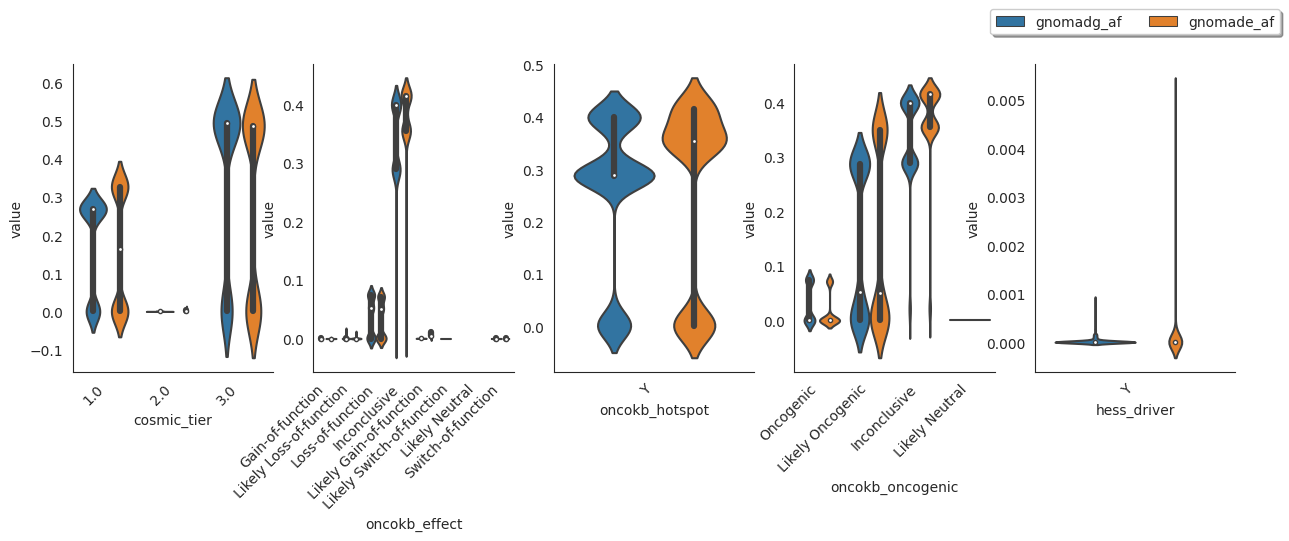

In [26]:
rescued_maf_variants = maf_variants_23q4.loc[maf_variants_23q4.rescue, :]
rescued_maf_variants_sub_categores = rescued_maf_variants.loc[:, ['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver', 'gnomadg_af', 'gnomade_af']].melt(id_vars=['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver'])

## Majority of the oncoKB hotspot mutation are also very pemissive
## They will introduce inclusive oncoKB mutation effects 
## Let's remove hotspot mutation for whitelisting ..
## May consider run hotspot method later

sns.set_style("white")
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(15, 4)
ax = ax.flatten()

sns.violinplot(data=rescued_maf_variants_sub_categores, x='cosmic_tier', y='value', hue='variable', ax=ax[0])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_effect', y='value', hue='variable', ax=ax[1])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_hotspot', y='value', hue='variable', ax=ax[2])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_oncogenic', y='value', hue='variable', ax=ax[3])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='hess_driver', y='value', hue='variable', ax=ax[4])

for ax_index, curr_ax in enumerate(ax):
    for tick in curr_ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
        sns.despine()
        if ax_index == 4:
            curr_ax.legend(bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True, loc='upper center')
        else:
            curr_ax.legend().set_visible(False)
#plt.tight_layout()


In [27]:
maf_variants_23q4.gnomadg_af.describe()

count    84338.000000
mean         0.030074
std          0.097442
min          0.000000
25%          0.000007
50%          0.000007
75%          0.000007
max          0.494600
Name: gnomadg_af, dtype: float64

In [28]:
count_rescued = pd.DataFrame(rescued_maf_variants.groupby("cds_id").apply(lambda x: x.shape[0])).reset_index().rename(
    columns={0: 'count'}
)

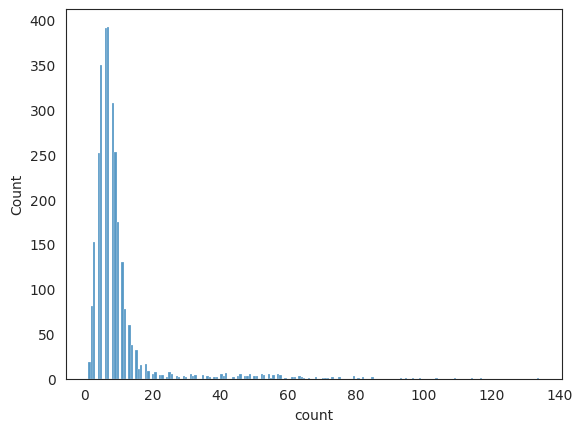

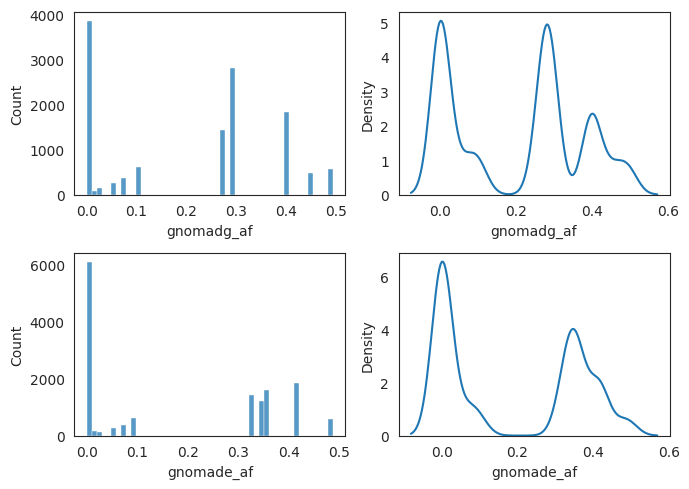

In [29]:
sns.histplot(count_rescued, x='count')

fig, ax = plt.subplots(2, 2)
sns.histplot(rescued_maf_variants.gnomadg_af, bins=50, ax=ax[0][0])
sns.kdeplot(rescued_maf_variants.gnomadg_af, ax=ax[0][1])
sns.histplot(rescued_maf_variants.gnomade_af, bins=50, ax=ax[1][0])
sns.kdeplot(rescued_maf_variants.gnomade_af, ax=ax[1][1])
fig.set_size_inches(7, 5)
fig.tight_layout()

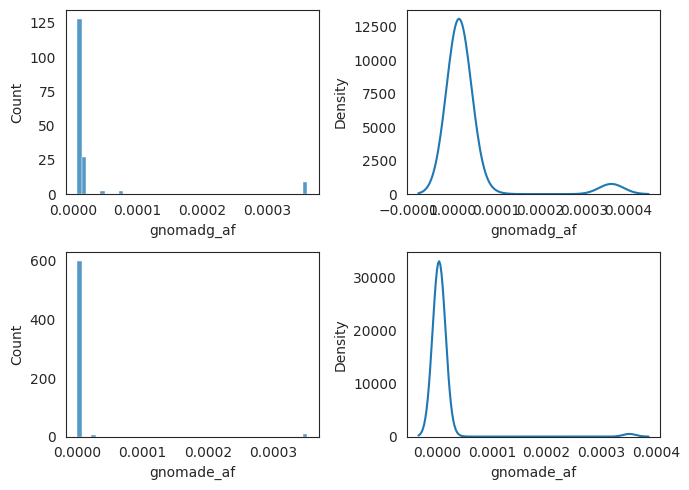

In [30]:
# Civic score has been removed from the rescue list
fig, ax = plt.subplots(2, 2)
sns.histplot(rescued_maf_variants.query('civic_score >= 50').gnomadg_af, bins=50, ax=ax[0][0])
sns.kdeplot(rescued_maf_variants.query('civic_score >= 50').gnomadg_af, ax=ax[0][1])
sns.histplot(rescued_maf_variants.query('civic_score >= 50').gnomade_af, bins=50, ax=ax[1][0])
sns.kdeplot(rescued_maf_variants.query('civic_score >= 50').gnomade_af, ax=ax[1][1])
fig.set_size_inches(7, 5)
fig.tight_layout()

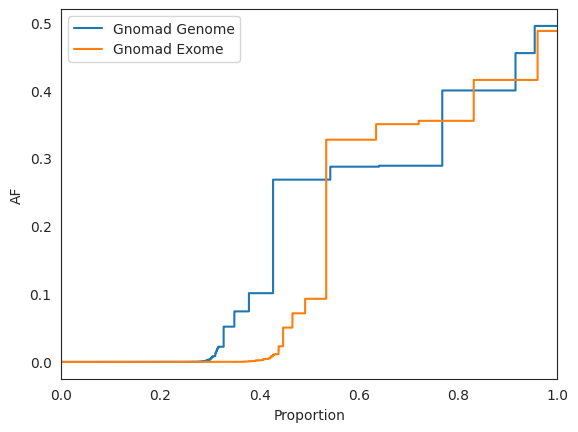

In [31]:
sns.ecdfplot(data=rescued_maf_variants, y="gnomadg_af", label='Gnomad Genome')
sns.ecdfplot(data=rescued_maf_variants, y="gnomade_af", label='Gnomad Exome')
plt.ylabel("AF")
plt.legend()

# Remove some rescue list to finalize a maf file

In [32]:
# Turn off hotspot rescue list 
# for both oncoKB and hess driver
maf_variants_23q4_clean = maf_variants_23q4.query("(oncokb_hotspot == 'Y') | (hess_driver == 'Y')")

# Only remove the hotspot with synonymous mutations and high allele frequency
maf_variants_23q4_clean = maf_variants_23q4.drop(maf_variants_23q4_clean.index[((maf_variants_23q4_clean.gnomadg_af > 1e-1) | (maf_variants_23q4_clean.gnomade_af > 1e-1)) & (maf_variants_23q4_clean.variant_info.str.contains("^syno", regex=True))], axis=0)

In [33]:
maf_variants_23q4_clean.shape, maf_variants_23q4.shape

((1124216, 83), (1124216, 83))

In [34]:
# With above filter of rescue list
# We still have ~110 synonymous mutations
# Remove synonymous mutation even with low gnomad af
# Unless there is very strong oncoKB support 
# any variants with leftmost (strongest) consequence is synonymous mutation 
# will be removed

maf_variants_23q4_clean = maf_variants_23q4_clean.loc[~maf_variants_23q4_clean.variant_info.str.contains('^synony', regex=True), ]

In [35]:
maf_variants_23q4_clean.shape

(1123963, 83)

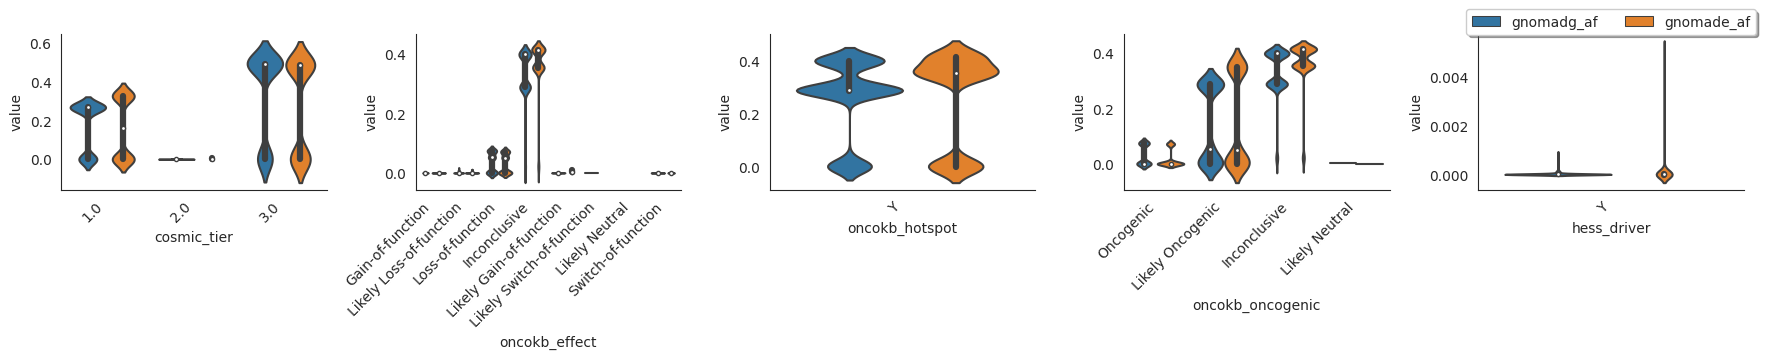

In [36]:
# Double check after removing hotspot rescue
rescued_maf_variants = maf_variants_23q4_clean.loc[maf_variants_23q4_clean.rescue, :]
rescued_maf_variants_sub_categores = rescued_maf_variants.loc[:, ['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver', 'gnomadg_af', 'gnomade_af']].melt(id_vars=['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver'])

## Majority of the oncoKB hotspot mutation are also very pemissive
## They will introduce inclusive oncoKB mutation effects 
## Let's remove hotspot mutation for whitelisting ..
## May consider run hotspot method later

sns.set_style("white")
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(18, 4)
ax = ax.flatten()

sns.violinplot(data=rescued_maf_variants_sub_categores, x='cosmic_tier', y='value', hue='variable', ax=ax[0])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_effect', y='value', hue='variable', ax=ax[1])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_hotspot', y='value', hue='variable', ax=ax[2])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_oncogenic', y='value', hue='variable', ax=ax[3])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='hess_driver', y='value', hue='variable', ax=ax[4])

for ax_index, curr_ax in enumerate(ax):
    for tick in curr_ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
        sns.despine()
        if ax_index == 4:
            curr_ax.legend(bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True, loc='upper center')
        else:
            curr_ax.legend().set_visible(False)
plt.tight_layout()

In [37]:
# Turn off oncoKB hotspot rescue list  
maf_variants_23q4_oncokb = maf_variants_23q4_clean.query("(oncokb_hotspot == 'Y')")

# Only remove the hotspot with synonymous mutations and high allele frequency
maf_variants_23q4_clean = maf_variants_23q4_clean.drop(maf_variants_23q4_oncokb.index[((maf_variants_23q4_oncokb.gnomadg_af > 1e-1) | (maf_variants_23q4_oncokb.gnomade_af > 1e-1)) | \
                                                                                       (maf_variants_23q4_oncokb.oncokb_effect.str.contains("^Inconclusive", regex=True))], axis=0)
maf_variants_23q4_clean.shape                                                                                    

(1119156, 83)

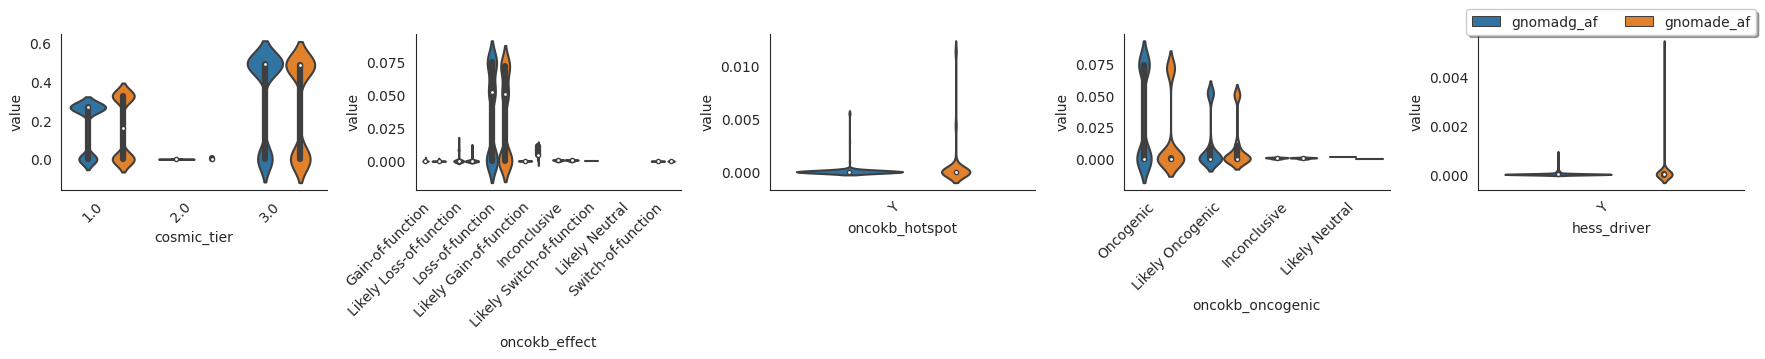

In [38]:
# Double check after removing hotspot rescue
rescued_maf_variants = maf_variants_23q4_clean.loc[maf_variants_23q4_clean.rescue, :]
rescued_maf_variants_sub_categores = rescued_maf_variants.loc[:, ['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver', 'gnomadg_af', 'gnomade_af']].melt(id_vars=['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver'])

## Majority of the oncoKB hotspot mutation are also very pemissive
## They will introduce inclusive oncoKB mutation effects 
## Let's remove hotspot mutation for whitelisting ..
## May consider run hotspot method later

sns.set_style("white")
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(18, 4)
ax = ax.flatten()

sns.violinplot(data=rescued_maf_variants_sub_categores, x='cosmic_tier', y='value', hue='variable', ax=ax[0])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_effect', y='value', hue='variable', ax=ax[1])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_hotspot', y='value', hue='variable', ax=ax[2])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_oncogenic', y='value', hue='variable', ax=ax[3])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='hess_driver', y='value', hue='variable', ax=ax[4])

for ax_index, curr_ax in enumerate(ax):
    for tick in curr_ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
        sns.despine()
        if ax_index == 4:
            curr_ax.legend(bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True, loc='upper center')
        else:
            curr_ax.legend().set_visible(False)
plt.tight_layout()

In [39]:
# Trim COSMIC tier 1 with high frequency
maf_variants_23q4_cosmic = maf_variants_23q4_clean.query("(cosmic_tier == 1) | (cosmic_tier == 3)")

# Only remove the hotspot with synonymous mutations and high allele frequency
maf_variants_23q4_clean = maf_variants_23q4_clean.drop(maf_variants_23q4_cosmic.index[((maf_variants_23q4_cosmic.gnomadg_af > 1e-1) | (maf_variants_23q4_cosmic.gnomade_af > 1e-1))], axis=0)

maf_variants_23q4_clean.shape                                                                                    

(1117155, 83)

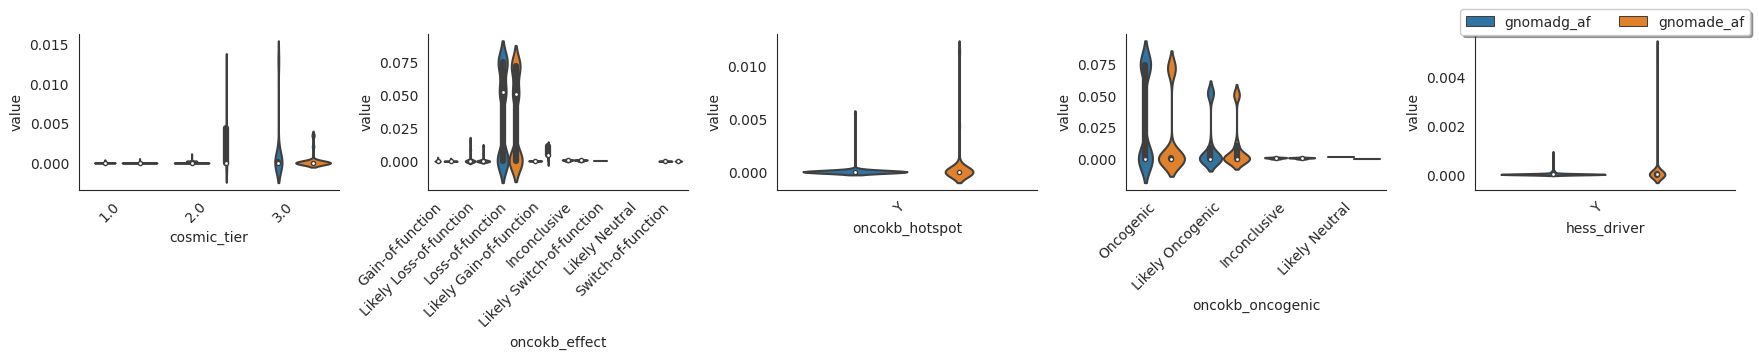

In [40]:
# Double check after removing hotspot rescue
rescued_maf_variants = maf_variants_23q4_clean.loc[maf_variants_23q4_clean.rescue, :]
rescued_maf_variants_sub_categores = rescued_maf_variants.loc[:, ['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver', 'gnomadg_af', 'gnomade_af']].melt(id_vars=['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver'])

## Majority of the oncoKB hotspot mutation are also very pemissive
## They will introduce inclusive oncoKB mutation effects 
## Let's remove hotspot mutation for whitelisting ..
## May consider run hotspot method later

sns.set_style("white")
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(18, 4)
ax = ax.flatten()

sns.violinplot(data=rescued_maf_variants_sub_categores, x='cosmic_tier', y='value', hue='variable', ax=ax[0])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_effect', y='value', hue='variable', ax=ax[1])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_hotspot', y='value', hue='variable', ax=ax[2])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_oncogenic', y='value', hue='variable', ax=ax[3])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='hess_driver', y='value', hue='variable', ax=ax[4])

for ax_index, curr_ax in enumerate(ax):
    for tick in curr_ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
        sns.despine()
        if ax_index == 4:
            curr_ax.legend(bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True, loc='upper center')
        else:
            curr_ax.legend().set_visible(False)
plt.tight_layout()

In [41]:
count_rescued = pd.DataFrame(rescued_maf_variants.groupby("cds_id").apply(lambda x: x.shape[0])).reset_index().rename(
    columns={0: 'count'}
)

count_rescued.mean()

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_15611/1973614276.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  count_rescued.mean()


count    7.413036
dtype: float64

<Axes: xlabel='count', ylabel='Count'>

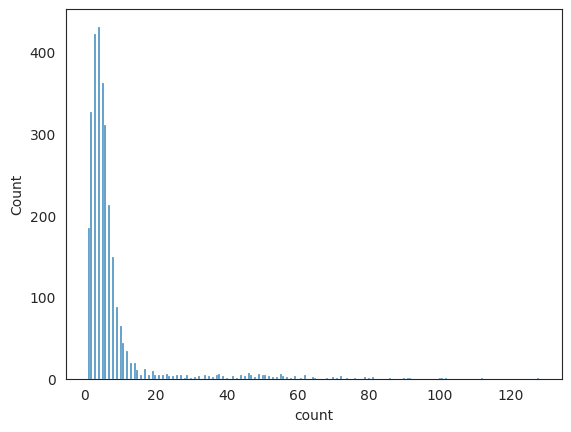

In [42]:
sns.histplot(count_rescued, x='count')

In [43]:
# Still have 71 variants with secondary effect belonging to synonymous mutation 
# Will be assigned to be silent mutation later according to maftools
# That seems to be important in oncoKB 

maf_variants_23q4_clean.query("variant_info.str.contains('syno')")[check_columns]

pos  gnomadg_af hess_driver vep_impact  cosmic_tier  \
1634     136517753    0.000677         NaN        LOW          NaN   
13370      7675994    0.000007           Y        LOW          NaN   
46530     69396546    0.000511         NaN        LOW          NaN   
47375      7675994    0.000007           Y        LOW          NaN   
47991     69396546    0.000511         NaN        LOW          NaN   
...            ...         ...         ...        ...          ...   
1081462  136514512    0.016090         NaN        LOW          NaN   
1082436    7675994         NaN           Y        LOW          NaN   
1089927  136513133    0.000053         NaN        LOW          NaN   
1108792  136514512    0.016090         NaN        LOW          NaN   
1123376  136514512    0.016090         NaN        LOW          NaN   

         civic_score                clnsig hugo_symbol vep_mane_select  \
1634             NaN  Benign/Likely_benign      NOTCH1     NM_017617.5   
13370            NaN            Pathogenic        TP53     NM_000546.6   
46530            NaN                   NaN       RAD17     NM_133338.3   
47375            NaN            Pathogenic        TP53     NM_000546.6   
47991            NaN                   NaN       RAD17     NM_133338.3   
...              ...                   ...         ...             ...   
1081462          NaN                Benign      NOTCH1     NM_017617.5   
1082436          NaN            Pathogenic        TP53     NM_000546.6   
1089927          NaN  Benign/Likely_benign      NOTCH1     NM_017617.5   
1108792          NaN                Benign      NOTCH1     NM_017617.5   
1123376          NaN                Benign      NOTCH1     NM_017617.5   

                                     variant_info  \
1634     splice_region_variant&synonymous_variant   
13370    splice_region_variant&synonymous_variant   
46530    splice_region_variant&synonymous_variant   
47375    splice_region_variant&synonymous_variant   
47991    splice_region_variant&synonymous_variant   
...                                           ...   
1081462  splice_region_variant&synonymous_variant   
1082436  splice_region_variant&synonymous_variant   
1089927  splice_region_variant&synonymous_variant   
1108792  splice_region_variant&synonymous_variant   
1123376  splice_region_variant&synonymous_variant   

                      protein_change  oncokb_oncogenic  \
1634     ENSP00000498587.1:p.Pro480=         Oncogenic   
13370    ENSP00000269305.4:p.Thr125=  Likely Oncogenic   
46530    ENSP00000346938.5:p.Lys524=  Likely Oncogenic   
47375    ENSP00000269305.4:p.Thr125=  Likely Oncogenic   
47991    ENSP00000346938.5:p.Lys524=  Likely Oncogenic   
...                              ...               ...   
1081462  ENSP00000498587.1:p.Asn735=         Oncogenic   
1082436  ENSP00000269305.4:p.Thr125=  Likely Oncogenic   
1089927  ENSP00000498587.1:p.Gly785=         Oncogenic   
1108792  ENSP00000498587.1:p.Asn735=         Oncogenic   
1123376  ENSP00000498587.1:p.Asn735=         Oncogenic   

                   oncokb_effect oncokb_hotspot  rescue  
1634     Likely Loss-of-function            NaN    True  
13370    Likely Loss-of-function              Y    True  
46530           Loss-of-function            NaN    True  
47375    Likely Loss-of-function              Y    True  
47991           Loss-of-function            NaN    True  
...                          ...            ...     ...  
1081462  Likely Loss-of-function            NaN    True  
1082436  Likely Loss-of-function              Y    True  
1089927  Likely Loss-of-function            NaN    True  
1108792  Likely Loss-of-function            NaN    True  
1123376  Likely Loss-of-function            NaN    True  

[71 rows x 15 columns]

In [44]:
# Double check St Jude InDel

## SKNAS	chr6.156778971..GCA	chr6.156778980.GG.GCAGG	InDel
## MONOMAC1	 chr11.47355346.GC.	 chr11.47355353.CGCC.CC
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.pos.isin(np.array([23803335, 7675067, 47355346, 68293321, 156778971, 226064457, 49041176]) - 1), check_columns]

pos  gnomadg_af hess_driver vep_impact  cosmic_tier  \
42149     23803334         NaN         NaN       HIGH          NaN   
69805     49041175         NaN         NaN       HIGH          NaN   
135669    23803334         NaN         NaN       HIGH          NaN   
153261    68293320         NaN         NaN   MODERATE          NaN   
252458     7675066         NaN         NaN       HIGH          NaN   
377942   226064456         NaN         NaN   MODERATE          NaN   
599019    49041175         NaN         NaN       HIGH          NaN   
743321    23803334         NaN         NaN       HIGH          NaN   
897521    49041175         NaN         NaN       HIGH          NaN   
955770    23803334         NaN         NaN       HIGH          NaN   
1000443  226064456         NaN         NaN   MODERATE          NaN   
1072895   68293320         NaN         NaN   MODERATE          NaN   
1105087    7675066         NaN         NaN       HIGH          NaN   
1117619   68293320         NaN         NaN   MODERATE          NaN   

         civic_score      clnsig hugo_symbol vep_mane_select  \
42149            NaN         NaN     SMARCB1     NM_003073.5   
69805            NaN  Pathogenic       KMT2D     NM_003482.4   
135669           NaN         NaN     SMARCB1     NM_003073.5   
153261           NaN         NaN      PIK3R1     NM_181523.3   
252458           NaN         NaN        TP53     NM_000546.6   
377942           NaN         NaN       H3-3A     NM_002107.7   
599019           NaN  Pathogenic       KMT2D     NM_003482.4   
743321           NaN         NaN     SMARCB1     NM_003073.5   
897521           NaN  Pathogenic       KMT2D     NM_003482.4   
955770           NaN         NaN     SMARCB1     NM_003073.5   
1000443          NaN         NaN       H3-3A     NM_002107.7   
1072895          NaN         NaN      PIK3R1     NM_181523.3   
1105087          NaN         NaN        TP53     NM_000546.6   
1117619          NaN         NaN      PIK3R1     NM_181523.3   

               variant_info                         protein_change  \
42149    frameshift_variant   ENSP00000494049.2:p.Gln182AlafsTer28   
69805    frameshift_variant  ENSP00000301067.7:p.Tyr2199IlefsTer65   
135669   frameshift_variant   ENSP00000494049.2:p.Gln182AlafsTer28   
153261     inframe_deletion          ENSP00000428056.1:p.Leu380del   
252458   frameshift_variant    ENSP00000269305.4:p.Arg174LeufsTer3   
377942    inframe_insertion  ENSP00000355780.3:p.Gly35_Val36insPhe   
599019   frameshift_variant  ENSP00000301067.7:p.Tyr2199IlefsTer65   
743321   frameshift_variant   ENSP00000494049.2:p.Gln182AlafsTer28   
897521   frameshift_variant  ENSP00000301067.7:p.Tyr2199IlefsTer65   
955770   frameshift_variant   ENSP00000494049.2:p.Gln182AlafsTer28   
1000443   inframe_insertion  ENSP00000355780.3:p.Gly35_Val36insPhe   
1072895    missense_variant          ENSP00000428056.1:p.Lys379Thr   
1105087  frameshift_variant    ENSP00000269305.4:p.Arg174LeufsTer3   
1117619    inframe_deletion          ENSP00000428056.1:p.Leu380del   

         oncokb_oncogenic            oncokb_effect oncokb_hotspot  rescue  
42149                 NaN                      NaN            NaN    True  
69805                 NaN                      NaN            NaN    True  
135669                NaN                      NaN            NaN    True  
153261                NaN                      NaN            NaN   False  
252458                NaN                      NaN            NaN    True  
377942                NaN                      NaN            NaN   False  
599019                NaN                      NaN            NaN    True  
743321                NaN                      NaN            NaN    True  
897521                NaN                      NaN            NaN    True  
955770                NaN                      NaN            NaN    True  
1000443               NaN                      NaN            NaN   False  
1072895  Likely Oncogenic  Likely Loss-o

# VCF 2 MAF standardised formatting to output 

## Convert coordinate and add essential standard MAF columns

In [45]:
def GetMafEndPosition(start: int, ref: str, alt: str) -> tuple:
    """Get the end position from the VCF start position and ref alt alleles

    Learn the complex InDel from https://github.com/qinqian/vcf2maf/blob/main/vcf2maf.pl#L706


    Return
    -----------
    (start, vartype, inframe): tuple
    """
    assert len(ref) > 0
    assert len(alt) > 0
    if len(ref) == len(alt):
        var_type_dict = {1: "SNP", 2: "DNP", 3: "TNP"}
        inframe = False
        if len(alt) > 3:
            var_type = "ONP"
        else:
            var_type = var_type_dict[len(alt)]
        return start, start + len(alt) - 1, var_type, inframe
    elif len(ref) < len(alt):
        # Insertion
        var_type = "INS";
        inframe = abs(len(ref) - len(alt)) % 3 == 0
        if ref == "-":
            return start - 1, start, var_type, inframe
        else:
            return start, start + len(ref) - 1, var_type, inframe
    else:
        # Deletion
        inframe = abs(len(ref) - len(alt)) % 3 == 0
        var_type = 'DEL'
        return start, start + len(ref) - 1, var_type, inframe

In [46]:
formatted_coords = maf_variants_23q4_clean.loc[:, ['pos', 'ref', 'alt']].apply(lambda x: GetMafEndPosition(*x), axis=1, result_type="expand")

In [47]:
import re

def GetVariantClassification(vep_seq_ontology: str, var_type: str, inframe: bool) -> str:
    """Map VEP sequence ontology into MAF variant classifications,
    VEP consequences is ordered by http://useast.ensembl.org/info/genome/variation/prediction/predicted_data.html"""

    if re.match(r"^(splice_acceptor_variant|splice_donor_variant|transcript_ablation|exon_loss_variant)", vep_seq_ontology):
        return "Splice_Site"
    
    if re.match(r"^(stop_gained)", vep_seq_ontology):
        return "Nonsense_Mutation"

    if (re.match(r"^(frameshift_variant)", vep_seq_ontology) or (re.match(r"^(protein_altering_variant)", vep_seq_ontology) and not inframe)) and (var_type == 'DEL'):
        return "Frame_Shift_Del"

    if (re.match(r"^(frameshift_variant)", vep_seq_ontology) or (re.match(r"^(protein_altering_variant)", vep_seq_ontology) and not inframe)) and (var_type == 'INS'):
        return "Frame_Shift_Ins"
    
    if re.match(r"^(stop_lost)", vep_seq_ontology):
        return "Nonstop_Mutation"
    
    if re.match(r"^(initiator_codon_variant|start_lost)", vep_seq_ontology):
        return "Translation_Start_Site" 

    if re.match(r"^(inframe_insertion|conservative_inframe_insertion|disruptive_inframe_insertion)", vep_seq_ontology) or (re.match(r"^(protein_altering_variant)", vep_seq_ontology) and inframe and (var_type == 'INS')):
        return "In_Frame_Ins"

    if re.match(r"^(inframe_deletion|disruptive_inframe_deletion|conservative_inframe_deletion)", vep_seq_ontology) or (re.match(r"^(protein_altering_variant)", vep_seq_ontology) and inframe and (var_type == 'DEL')):
        return "In_Frame_Del"

    if re.match(r"^(missense_variant|coding_sequence_variant|conservative_missense_variant|rare_amino_acid_variant)", vep_seq_ontology):
        return "Missense_Mutation"

    if re.match(r"^(transcript_amplification|intron_variant|INTRAGENIC|intragenic_variant)", vep_seq_ontology):
        return "Intron"

    if re.match(r"^(incomplete_terminal_codon_variant|synonymous_variant|stop_retained_variant|NMD_transcript_variant|start_retained_variant)", vep_seq_ontology):
        return "Silent"

    if re.match(r"^(splice_region_variant|splice_polypyrimidine_tract_variant|splice_donor_5th_base_variant|splice_donor_region_variant)", vep_seq_ontology):
        return "Splice_Region"

    if re.match(r"^(mature_miRNA_variant|exon_variant|non_coding_exon_variant|non_coding_transcript_exon_variant|non_coding_transcript_variant|nc_transcript_variant|coding_transcript_variant)", vep_seq_ontology):
        return "RNA"

    if re.match(r"^(5_prime_UTR_variant|5_prime_UTR_premature_start_codon_gain_variant)", vep_seq_ontology):
        return "5'UTR"

    if re.match(r"^3_prime_UTR_variant", vep_seq_ontology):
        return "3'UTR"

    if re.match(r"^upstream_gene_variant", vep_seq_ontology):
        return "5'Flank"

    if re.match(r"^downstream_gene_variant", vep_seq_ontology):
        return "3'Flank"

    if re.match(r"^(TF_binding_site_variant|regulatory_region_variant|regulatory_region|intergenic_variant|intergenic_region)", vep_seq_ontology):
        return "IGR" 

    if vep_seq_ontology == "":
        return "NoAnnotation"

    return "TargetedRegion"


In [48]:
maf_variants_23q4_clean['Start_Position'] = formatted_coords[0]
maf_variants_23q4_clean['End_Position'] = formatted_coords[1]
maf_variants_23q4_clean['Variant_Type'] = formatted_coords[2]
maf_variants_23q4_clean['InFrame'] = formatted_coords[3]
maf_variants_23q4_clean['Variant_Classification'] = maf_variants_23q4_clean.loc[:, ['variant_info', 'Variant_Type', 'InFrame']].apply(lambda x: GetVariantClassification(*x), axis=1)

In [49]:
maf_variants_23q4_clean.shape, maf_variants_23q4_clean.query("Variant_Classification == 'Silent'").values

((1117155, 88),
 array([[397, 110838, 'chr14', 105865551, 'T', 'TA', 0.75, 2, 0, 2, '0|1',
         105865532.0, 'insertion',
         'incomplete_terminal_codon_variant&coding_sequence_variant',
         'ENST00000439842.1:c.10_11insT', 'ENSP00000418639.1:p.Ter4Val',
         'IGHD7-27', 'ENSG00000236597', 'ENST00000439842',
         'immunoglobulin heavy diversity 7-27',
         'Immunoglobulin heavy locus at 14q32.33', nan, nan, 0.6475, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, 'LOW', 'IG_D_gene',
         'HGNC:5518', nan, nan, 'ENSP00000418639', nan, nan, nan, nan,
         nan, nan, nan, nan, nan, False, False, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, 7.3, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         False, 'CDS-Qkc4aS', 105865551, 105865551, 'INS', False,
         'Silent']], dtype=object))

In [50]:
# Remove the silent mutation that are mixed with missense mutation 
# Using different consequeces names

maf_variants_23q4_clean = maf_variants_23q4_clean.query("Variant_Classification != 'Silent'")

In [51]:
# No missing annotations
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.Variant_Classification == 'TargetedRegion', ['ref', 'alt', 'variant_info', 'Variant_Classification', 'variant_info', 'Variant_Type', 'InFrame']].values

array([], shape=(0, 7), dtype=object)

In [52]:
maf_variants_23q4_clean.Variant_Classification.unique()

array(['Missense_Mutation', 'Frame_Shift_Del', 'Nonsense_Mutation',
       'Splice_Site', 'In_Frame_Del', 'In_Frame_Ins', 'Frame_Shift_Ins',
       "5'Flank", 'Nonstop_Mutation', 'Translation_Start_Site',
       'Splice_Region', "3'Flank", 'Intron', "5'UTR", 'RNA'], dtype=object)

In [53]:
maf_variants_23q4_clean.head()

Unnamed: 0  0915 chrom      pos ref alt     af   dp  ref_count  alt_count  \
0           0    68  chr1   956200   T   C  0.238   65         50         15   
1           1   280  chr1  1331523   C   A  0.175   15         13          2   
2           2   444  chr1  1625579   A   G  0.373    6          4          2   
3           3  1251  chr1  5863353   C   T  0.541  273        126        147   
4           4  1323  chr1  6154744   T   G  0.206   26         21          5   

   ... provean_prediction  segdup   rm rescue      cds_id Start_Position  \
0  ...            Neutral     NaN  NaN  False  CDS-0Hians         956200   
1  ...            Neutral     NaN  NaN  False  CDS-0Hians        1331523   
2  ...           Damaging     NaN  NaN  False  CDS-0Hians        1625579   
3  ...            Neutral     NaN  NaN  False  CDS-0Hians        5863353   
4  ...            Neutral     NaN  NaN  False  CDS-0Hians        6154744   

  End_Position Variant_Type InFrame Variant_Classification  
0       956200          SNP   False      Missense_Mutation  
1      1331523          SNP   False      Missense_Mutation  
2      1625579          SNP   False      Missense_Mutation  
3      5863353          SNP   False      Missense_Mutation  
4      6154744          SNP   False      Missense_Mutation  

[5 rows x 88 columns]

## Reorder columns to keep consistent with MAF standards

In [54]:
maf_variants_23q4_clean.columns

Index(['Unnamed: 0', '0915', 'chrom', 'pos', 'ref', 'alt', 'af', 'dp',
       'ref_count', 'alt_count', 'gt', 'ps', 'variant_type', 'variant_info',
       'dna_change', 'protein_change', 'hugo_symbol', 'ensembl_gene_id',
       'ensembl_feature_id', 'hgnc_name', 'hgnc_family', 'uniprot_id',
       'dbsnp_rs_id', 'gc_content', 'lof_gene_name', 'lof_gene_id',
       'lof_number_of_transcripts_in_gene',
       'lof_percent_of_transcripts_affected', 'nmd', 'clnsig',
       'molecular_consequence', 'af_exac', 'af_esp', 'af_tgp', 'vep_impact',
       'vep_biotype', 'vep_hgnc_id', 'vep_existing_variation',
       'vep_mane_select', 'vep_ensp', 'vep_swissprot', 'sift', 'polyphen',
       'gnomade_af', 'gnomadg_af', 'vep_clin_sig', 'vep_somatic',
       'vep_pli_gene_value', 'vep_loftool', 'oncogene_high_impact',
       'tumor_suppressor_high_impact', 'achilles_top_genes',
       'structural_relation', 'associated_with', 'lof', 'driver',
       'likely_driver', 'transcript_likely_lof', 'brca1_f

In [55]:
maf_variants_23q4_clean['Strand'] = '+'
maf_variants_23q4_clean.rename(
    columns={
        "hugo_symbol": "Hugo_Symbol",
        "chrom": "Chromosome",
        "ref": "Reference_Allele",
        "alt": "Alternate_Allele",
        "cds_id": "Tumor_Sample_Barcode",
        "protein_change": "Protein_Change",
    },
    inplace=True,
)

In [56]:
maf_variants_23q4_clean.loc[:, "NCBI_Build"] = "GRCh38" 
maf_variants_23q4_clean.loc[:, "Center"] = "DepMap" 


In [57]:
maf_variants_23q4_clean.loc[:, "Tumor_Seq_Allele1"] = maf_variants_23q4_clean.loc[
    :, "Reference_Allele"
] 
maf_variants_23q4_clean.loc[:, "Tumor_Seq_Allele2"] = maf_variants_23q4_clean.loc[:, "Alternate_Allele"]

In [58]:
reordered_columns = [
        "Hugo_Symbol",
        "NCBI_Build",
        "Chromosome",
        "Start_Position",
        "End_Position",
        "Variant_Type",
        "Reference_Allele",
        "Tumor_Seq_Allele1",
        "Tumor_Seq_Allele2",
        "Tumor_Sample_Barcode",
        "Variant_Classification",
        "Protein_Change",
    ] 

In [59]:
reordered_columns += list(set(maf_variants_23q4_clean.columns) - set(reordered_columns))

In [60]:
maf_variants_23q4_clean = maf_variants_23q4_clean.loc[:, reordered_columns]

In [61]:
maf_variants_23q4_clean.shape

(1117154, 93)

In [62]:
maf_variants_23q4_clean.head()

Hugo_Symbol NCBI_Build Chromosome  Start_Position  End_Position  \
0       NOC2L     GRCh38       chr1          956200        956200   
1      TAS1R3     GRCh38       chr1         1331523       1331523   
2        MIB2     GRCh38       chr1         1625579       1625579   
3       NPHP4     GRCh38       chr1         5863353       5863353   
4        CHD5     GRCh38       chr1         6154744       6154744   

  Variant_Type Reference_Allele Tumor_Seq_Allele1 Tumor_Seq_Allele2  \
0          SNP                T                 T                 C   
1          SNP                C                 C                 A   
2          SNP                A                 A                 G   
3          SNP                C                 C                 T   
4          SNP                T                 T                 G   

  Tumor_Sample_Barcode  ...                  polyphen  Center  \
0           CDS-0Hians  ...             benign(0.057)  DepMap   
1           CDS-0Hians  ...                 benign(0)  DepMap   
2           CDS-0Hians  ...  probably_damaging(0.964)  DepMap   
3           CDS-0Hians  ...             benign(0.052)  DepMap   
4           CDS-0Hians  ...             benign(0.138)  DepMap   

  brca1_func_score  af_exac  molecular_consequence popaf uniprot_id  \
0              NaN      NaN                    NaN   7.3        NaN   
1              NaN      NaN                    NaN   7.3        NaN   
2              NaN      NaN                    NaN   7.3   Q96AX9-1   
3              NaN      NaN                    NaN   7.3   O75161-1   
4              NaN      NaN                    NaN   7.3        NaN   

       variant_info  lof_gene_name transcript_likely_lof  
0  missense_variant            NaN                   NaN  
1  missense_variant            NaN                   NaN  
2  missense_variant            NaN                   NaN  
3  missense_variant            NaN                   NaN  
4  missense_variant            NaN                   NaN  

[5 rows x 93 columns]

In [63]:
maf_variants_23q4_clean.Variant_Classification.unique()

array(['Missense_Mutation', 'Frame_Shift_Del', 'Nonsense_Mutation',
       'Splice_Site', 'In_Frame_Del', 'In_Frame_Ins', 'Frame_Shift_Ins',
       "5'Flank", 'Nonstop_Mutation', 'Translation_Start_Site',
       'Splice_Region', "3'Flank", 'Intron', "5'UTR", 'RNA'], dtype=object)

In [64]:
maf_variants_23q4_clean.Variant_Classification.value_counts()

Missense_Mutation         924368
Frame_Shift_Del            58906
Nonsense_Mutation          57860
Splice_Site                38753
Frame_Shift_Ins            20495
In_Frame_Del                9246
In_Frame_Ins                3422
Translation_Start_Site      2234
Nonstop_Mutation            1380
5'Flank                      389
Splice_Region                 69
3'Flank                       13
5'UTR                          7
Intron                         6
RNA                            6
Name: Variant_Classification, dtype: int64

In [65]:
maf_variants_23q4_clean.shape[0] - maf_variants_23q4_clean.Variant_Classification.value_counts()[-6:].sum()

1116664

In [66]:
# Filter based on maftools criterion of what is Silent mutations
# Exclude the following classifications

maf_variants_23q4_clean = maf_variants_23q4_clean.loc[~maf_variants_23q4_clean.Variant_Classification.isin(['RNA', 'Intron', "5'UTR", "3'Flank", 'Splice_Region', "5'Flank"]), :]
maf_variants_23q4_clean.shape

(1116664, 93)

In [67]:
# Remove variants without Hugo_Symbol

maf_variants_23q4_clean = maf_variants_23q4_clean.loc[~maf_variants_23q4_clean.Hugo_Symbol.isnull(), :]

In [68]:
maf_variants_23q4_clean.shape

(1113655, 93)

In [69]:
maf_variants_23q4_clean = maf_variants_23q4_clean.sort_values(by=["Chromosome", "Start_Position", "End_Position"])

In [70]:
oncotree_meta_profile = pd.read_table("~/all_meta_oncotree.tsv")

In [72]:
maf_variants_23q4_clean['oncotree'] = maf_variants_23q4_clean.Tumor_Sample_Barcode.map(dict(zip(oncotree_meta_profile['MainSequencingID'], oncotree_meta_profile['depmap_model_type'])))


In [73]:
maf_variants_23q4_clean['celltype'] = maf_variants_23q4_clean.Tumor_Sample_Barcode.map(dict(zip(oncotree_meta_profile['MainSequencingID'], oncotree_meta_profile['StrippedCellLineName'])))

In [131]:
oncotree_meta_profile.columns

Index(['ProfileID', 'Registered', 'OmicsOrderDate',
       'OmicsProfileFundingSource', 'SMIDOrdered', 'SMIDReturned', 'PDOID',
       'OmicsReturnDate', 'BamPublicSRAPath', 'MainSequencingID',
       'BlacklistOmics', 'Issue', 'Prioritized', 'ProposedReleaseDate',
       'PublicReleaseDate', 'ConsortiumReleaseDate', 'InternalReleaseDate',
       'IBMReleaseDate', 'Deliverables', 'OmicsProfileFlagship',
       'DestinationDatasets', 'BlacklistReason', 'BlacklistExpirationDate',
       'billing_date', 'Baits', 'Datatype', 'KitID', 'ModelCondition',
       'ProfileSource', 'Status', 'Workspace', 'actual_seq_technology',
       'bsp_sample_id_csv', 'cell_available', 'cell_pellet_needed',
       'collaborator_sample_id', 'eta_for_omics_completion',
       'extraction_needed', 'lcset_protocol', 'lcsets', 'line_received_by_gp',
       'line_sent_to_gp', 'pdo_title', 'pf_bases_bc', 'product',
       'product_goal', 'project', 'quote_to_bill', 'resubmit_for_extraction',
       'rna_delivery_da

In [135]:
maf_variants_23q4_clean['Datatype'] = maf_variants_23q4_clean.Tumor_Sample_Barcode.map(dict(zip(oncotree_meta_profile['MainSequencingID'], oncotree_meta_profile['Datatype'])))

In [211]:
maf_variants_23q4_clean['ModelID'] = maf_variants_23q4_clean.Tumor_Sample_Barcode.map(dict(zip(oncotree_meta_profile['MainSequencingID'], oncotree_meta_profile['ModelID'])))

In [75]:
# Missing oncotree information
# For the following information
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.oncotree.isnull(), 'Tumor_Sample_Barcode'].unique()

array(['CDS-9MaK5m', 'CDS-9dmbNr', 'CDS-l4hN5a', 'CDS-xvtYY4',
       'CDS-VBZICX', 'CDS-H5pYSo', 'CDS-m9etwI', 'CDS-3PGQ84',
       'CDS-qg5DNs', 'CDS-SyNck6', 'CDS-mys9Dm', 'CDS-e87T3y',
       'CDS-243Iiz', 'CDS-0DgVJy', 'CDS-p5raBU', 'CDS-0Fwtih',
       'CDS-mYOC4j', 'CDS-iXzCuK', 'CDS-osyj6m', 'CDS-o86jP7',
       'CDS-Wszh2o', 'CDS-5VSzNX', 'CDS-PYOe18', 'CDS-Qcyabl',
       'CDS-JfSOor', 'CDS-TzQAjG', 'CDS-VNR5t7', 'CDS-UVR5rq',
       'CDS-LwmNzj', 'CDS-KKUwpO', 'CDS-v16nfN', 'CDS-1ylR0Q',
       'CDS-C2RlCj', 'CDS-Rl87Z1', 'CDS-kZeKcd', 'CDS-rUhwew',
       'CDS-5bn1Sn', 'CDS-BLsNdt', 'CDS-RL0MET', 'CDS-9131qh',
       'CDS-2MqQMN', 'CDS-8GqFo5', 'CDS-ZiiXfY', 'CDS-rKqw5L',
       'CDS-H8AM79', 'CDS-JLbCKR', 'CDS-YNevBD', 'CDS-wYSBN2',
       'CDS-MC8G3c', 'CDS-YF6KJn', 'CDS-aHVCL2', 'CDS-k47lqZ',
       'CDS-dIijHP', 'CDS-RDBHMv', 'CDS-rBJABr', 'CDS-9AGvvZ',
       'CDS-mPSGp7', 'CDS-VjVlxw'], dtype=object)

In [76]:
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.celltype.isnull(), 'Tumor_Sample_Barcode'].unique()

array(['CDS-9dmbNr', 'CDS-l4hN5a', 'CDS-xvtYY4', 'CDS-VBZICX',
       'CDS-H5pYSo', 'CDS-m9etwI', 'CDS-3PGQ84', 'CDS-qg5DNs',
       'CDS-SyNck6', 'CDS-mys9Dm', 'CDS-e87T3y', 'CDS-243Iiz',
       'CDS-0DgVJy', 'CDS-p5raBU', 'CDS-0Fwtih', 'CDS-mYOC4j',
       'CDS-iXzCuK', 'CDS-osyj6m', 'CDS-o86jP7', 'CDS-Wszh2o',
       'CDS-5VSzNX', 'CDS-PYOe18', 'CDS-Qcyabl', 'CDS-JfSOor',
       'CDS-TzQAjG', 'CDS-VNR5t7', 'CDS-UVR5rq', 'CDS-LwmNzj',
       'CDS-KKUwpO', 'CDS-v16nfN', 'CDS-C2RlCj', 'CDS-Rl87Z1',
       'CDS-kZeKcd', 'CDS-rUhwew', 'CDS-5bn1Sn', 'CDS-BLsNdt',
       'CDS-RL0MET', 'CDS-9131qh', 'CDS-2MqQMN', 'CDS-8GqFo5',
       'CDS-ZiiXfY', 'CDS-rKqw5L', 'CDS-H8AM79', 'CDS-JLbCKR',
       'CDS-YNevBD', 'CDS-wYSBN2', 'CDS-MC8G3c', 'CDS-YF6KJn',
       'CDS-aHVCL2', 'CDS-k47lqZ', 'CDS-dIijHP', 'CDS-RDBHMv',
       'CDS-rBJABr', 'CDS-9AGvvZ', 'CDS-mPSGp7', 'CDS-VjVlxw'],
      dtype=object)

In [77]:
maf_variants_23q4_clean.celltype[:5]

878643    RERFLCMS
824858     MAMEL46
960101      DS117T
291228    NCIH1993
796668    SUM159PT
Name: celltype, dtype: object

## Internal cohort AF

In [78]:
# Interal cohort allele frequencies filtering

internal_afs_23q4 = maf_variants_23q4_clean.loc[:, ['Chromosome', 'Start_Position', 'End_Position', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2']].apply(lambda x: ':'.join(map(str, x)), axis=1)

In [79]:
total_samples = maf_variants_23q4_clean.Tumor_Sample_Barcode.unique().shape[0]

In [80]:
from collections import Counter

# assume there are very few duplicated variants per sample
# actually we have total 4 duplicated variants, it is trivial

internal_afs_23q4_ratio_dict = {}
for k, v in Counter(internal_afs_23q4.tolist()).items():
    internal_afs_23q4_ratio_dict[k] = v / total_samples

In [93]:
# https://github.com/broadinstitute/depmap_omics/blob/update-vcf-to-depmap/depmapomics/mutations.py#L39

maf_variants_23q4_clean["internal_afs_23q4"] = internal_afs_23q4.map(internal_afs_23q4_ratio_dict)

In [94]:
maf_variants_23q4_clean["internal_afs_23q4"].describe()

count    1.113655e+06
mean     1.855431e-02
std      9.895542e-02
min      3.404835e-04
25%      3.404835e-04
50%      6.809670e-04
75%      6.809670e-04
max      9.867211e-01
Name: internal_afs_23q4, dtype: float64

In [83]:
maf_variants_23q4_clean.to_csv("23Q4_somatic_mutations_profile_drafted.maf", index=False, sep='\t')
max_recurrence = 0.01 
maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence").to_csv(f"23Q4_somatic_mutations_profile_drafted_internal_af{max_recurrence}.maf", index=False, sep='\t')

In [138]:
maf_variants_23q4_clean.query("Datatype=='wgs'").to_csv("23Q4_somatic_mutations_profile_drafted_wgs.maf", index=False, sep='\t')
max_recurrence = 0.01 
maf_variants_23q4_clean.query("(internal_afs_23q4 <= @max_recurrence) & (Datatype=='wgs')").to_csv(f"23Q4_somatic_mutations_profile_drafted_internal_af{max_recurrence}_wgs.maf", index=False, sep='\t')

In [104]:
maf_variants_23q4_clean.sift.isnull().sum(), maf_variants_23q4_clean.shape

(245862, (1113655, 96))

In [107]:
maf_variants_23q4_clean.provean_prediction.isnull().sum()

322421

In [116]:
# Do we need to exclude neutral mutation ??
(maf_variants_23q4_clean.provean_prediction == 'Neutral').sum(), maf_variants_23q4_clean.polyphen.str.contains('^benign', regex=True).sum()

(435824, 375884)

In [120]:
(maf_variants_23q4_clean.Hugo_Symbol == 'MUC3A').sum(), maf_variants_23q4_clean.shape

(7986, (1113655, 96))

In [124]:
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.Hugo_Symbol == 'TTN', :].value_counts("oncotree")[:20]

oncotree
COAD        599
MEL         507
SCLC        310
LUAD        267
UCEC        203
STAD        125
LUSC         97
GB           91
SKCM         89
PAAD         84
NSCLC        73
ESCC         71
OCSC         71
TLL          65
PRAD         58
BRCA         53
BLL          52
ESCA         51
UASC         43
DLBCLNOS     42
dtype: int64

In [126]:
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.Hugo_Symbol == 'MUC3A', :]

Hugo_Symbol NCBI_Build Chromosome  Start_Position  End_Position  \
1114784       MUC3A     GRCh38       chr7       100949645     100949646   
1114785       MUC3A     GRCh38       chr7       100949647     100949647   
724207        MUC3A     GRCh38       chr7       100949661     100949661   
461468        MUC3A     GRCh38       chr7       100949664     100949664   
475230        MUC3A     GRCh38       chr7       100949670     100949672   
...             ...        ...        ...             ...           ...   
235263        MUC3A     GRCh38       chr7       100966937     100966937   
228736        MUC3A     GRCh38       chr7       100966949     100966949   
1047792       MUC3A     GRCh38       chr7       100966949     100966949   
939100        MUC3A     GRCh38       chr7       100967134     100967134   
830042        MUC3A     GRCh38       chr7       100967149     100967149   

        Variant_Type Reference_Allele Tumor_Seq_Allele1 Tumor_Seq_Allele2  \
1114784          DEL               CG                CG                 C   
1114785          SNP                G                 G                 T   
724207           SNP                C                 C                 A   
461468           SNP                A                 A                 G   
475230           DEL              TCC               TCC                 T   
...              ...              ...               ...               ...   
235263           SNP                G                 G                 A   
228736           SNP                A                 A                 G   
1047792          SNP                A                 A                 G   
939100           SNP                G                 G                 A   
830042           SNP                C                 C                 T   

        Tumor_Sample_Barcode  ... af_exac molecular_consequence popaf  \
1114784           CDS-YSRYLi  ...     NaN                   NaN   7.3   
1114785           CDS-YSRYLi  ...     NaN                   NaN   7.3   
724207            CDS-waif9Z  ...     NaN                   NaN   7.3   
461468            CDS-MmcZTk  ...     NaN                   NaN   7.3   
475230            CDS-N6ol9n  ...     NaN                   NaN   7.3   
...                      ...  ...     ...                   ...   ...   
235263            CDS-ddHWZJ  ...     NaN                   NaN   7.3   
228736            CDS-d1P2GJ  ...     NaN                   NaN   7.3   
1047792           CDS-QM6I45  ...     NaN                   NaN   7.3   
939100            CDS-fSBbM3  ...     NaN                   NaN   7.3   
830042            CDS-2I6NbU  ...     NaN                   NaN   7.3   

         uniprot_id                            variant_info lof_gene_name  \
1114784    Q02505-1                      frameshift_variant           NaN   
1114785    Q02505-1                        missense_variant           NaN   
724207     Q02505-1                        missense_variant           NaN   
461468     Q02505-1                        missense_variant           NaN   
475230     Q02505-1                      frameshift_variant           NaN   
...             ...                                     ...           ...   
235263     Q02505-1                        missense_variant           NaN   
228736     Q02505-1  missense_variant&splice_region_variant           NaN   
1047792    Q02505-1  missense_variant&splice_region_variant           NaN   
939100     Q02505-1                        missense_variant           NaN   
830042     Q02505-1                        missense_variant           NaN   

        transcript_likely_lof oncotree    celltype internal_afs_23q4  
1114784                   NaN     UCEC      JHUEM1          0.000340  
1114785                   NaN     UCEC      JHUEM1          0.000340  
724207                    NaN     LUAD    NCIH2342          0.000340  
461468                    NaN     UCEC      HEC108          0.000340  
475230                   

In [123]:
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.Hugo_Symbol == 'MUC3A', :].value_counts("oncotree")[:20]

oncotree
SCLC     416
GB       408
MEL      388
PAAD     357
LUAD     335
COAD     291
OCSC     210
STAD     204
IDC      178
HGSOC    178
ES       154
AML      139
BRCA     139
ESCA     138
ESCC     134
NBL      133
OS       122
LUSC     117
UCEC     117
HCC      111
dtype: int64

In [125]:
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.Hugo_Symbol == 'MUC3A', :].value_counts("provean_prediction")

provean_prediction
Damaging    10
Neutral      9
dtype: int64

In [96]:
# Too many oncotree information
maf_variants_23q4_clean.oncotree.unique().shape, maf_variants_23q4_clean.oncotree.unique()

((218,),
 array(['LUAD', 'MEL', 'BRCA', 'RCC', 'PAAD', 'ESCC', 'DLBCLNOS', 'BLL',
        'ESCA', 'COAD', 'IDC', 'STAD', 'OCSC', 'PRAD', 'AML', 'CCOV',
        'MBL', 'HGSOC', 'UCCA', 'LUSC', 'TLL', 'ES', 'CCRCC', 'BLCA',
        'ATRT', nan, 'UCEC', 'SKCM', 'HCC', 'CML', 'LCLC', 'EOV', 'ARMS',
        'SCLC', 'GB', 'MCC', 'BPLL', 'UASC', 'NBL', 'ATLL', 'STAS',
        'NSCLC', 'SOC', 'TSTAD', 'LUCA', 'FIBS', 'BL', 'COADREAD', 'LIPO',
        'AMOL', 'READ', 'MNG', 'ZIMMBL', 'EMBCA', 'ALCLALKN', 'CEAD', 'OS',
        'HNSC', 'HCL', 'ZHYPP', 'GCB', 'PLBMESO', 'ALCLALKP', 'BNNOS',
        'ASTR', 'PCM', 'ILC', 'PLEMESO', 'MFH', 'CMLBCRABL1', 'HL', 'MTNN',
        'DSTAD', 'NKCLL', 'ZMNOR', 'AM', 'LUAS', 'LXSC', 'ACRM', 'AMPCA',
        'CLLSLL', 'CEGCC', 'ZFIBSKI', 'PEL', 'HCCIHCH', 'TT', 'ASPS',
        'AASTR', 'UM', 'PMBL', 'MRT', 'PANET', 'MOV', 'HSTCL', 'VSC',
        'THAP', 'CSCC', 'PAASC', 'ECAD', 'ALAL', 'CESC', 'LMS', 'MBN',
        'MACR', 'LUMEC', 'BLSC', 'RMS', 'MYCF', 'IHCH

In [86]:
# Splitted mafs by the oncotree informations 

# for cancer_type in maf_variants_23q4_clean.oncotree.unique():
for cancer_type in ['READ', 'ESCA', 'AML', 'LUSC', 'SKCM']:
    print(cancer_type)
    cancer_type_maf = maf_variants_23q4_clean.query("oncotree == @cancer_type")
    cancer_type_maf.to_csv(f"23Q4_somatic_mutations_profile_drafted_{cancer_type}.maf", index=False, sep='\t')

READ
ESCA
AML
LUSC
SKCM


In [97]:
# Splitted mafs by the oncotree informations 

# for cancer_type in maf_variants_23q4_clean.oncotree.unique():
for cancer_type in ['READ', 'ESCA', 'AML', 'LUSC', 'LUAD', 'SKCM']:
    print(cancer_type)
    cancer_type_maf = maf_variants_23q4_clean.query("(oncotree == @cancer_type) & (internal_afs_23q4 < @max_recurrence)")
    cancer_type_maf.to_csv(f"23Q4_somatic_mutations_profile_drafted_{cancer_type}_internal_af{max_recurrence}.maf", index=False, sep='\t')

READ
ESCA
AML
LUSC
LUAD
SKCM


In [139]:
# Splitted mafs by the oncotree informations 

# for cancer_type in maf_variants_23q4_clean.oncotree.unique():
for cancer_type in ['READ', 'ESCA', 'AML', 'LUSC', 'LUAD', 'SKCM']:
    print(cancer_type)
    cancer_type_maf = maf_variants_23q4_clean.query("(oncotree == @cancer_type) & (internal_afs_23q4 < @max_recurrence) & (Datatype == 'wgs')")
    cancer_type_maf.to_csv(f"23Q4_somatic_mutations_profile_drafted_{cancer_type}_internal_af{max_recurrence}_wgs.maf", index=False, sep='\t')

READ
ESCA
AML
LUSC
LUAD
SKCM


In [98]:
# Merge all the subtypes of ovarian cancers
maf_variants_23q4_clean_ov_type = maf_variants_23q4_clean.loc[~maf_variants_23q4_clean.oncotree.isnull(), :]
maf_variants_23q4_clean_ov_type = maf_variants_23q4_clean_ov_type.loc[maf_variants_23q4_clean_ov_type.oncotree.str.contains('OV'), :]
maf_variants_23q4_clean_ov_type.to_csv(f"23Q4_somatic_mutations_profile_drafted_OV.maf", index=False, sep='\t')

In [99]:
maf_variants_23q4_clean_ov_type = maf_variants_23q4_clean.loc[~maf_variants_23q4_clean.oncotree.isnull(), :]
maf_variants_23q4_clean_ov_type = maf_variants_23q4_clean_ov_type.loc[(maf_variants_23q4_clean_ov_type.oncotree.str.contains('OV')) & (maf_variants_23q4_clean_ov_type.internal_afs_23q4 < max_recurrence), :]
maf_variants_23q4_clean_ov_type.to_csv(f"23Q4_somatic_mutations_profile_drafted_OV_internal_af{max_recurrence}.maf", index=False, sep='\t')

# Check sample specific question

## 1. The mutations of MTAP don't match with uniprot and ncbi

I found that many of the mutations of MTAP (Uniprot ID: Q13126) don’t match with any sequence from uniprot or ncbi. For example, HCT116 has a mutation p.V106A, but on uniprot, the 106 should be R. And there are many other mutations of MTAP have the same problem.

Answer: We actually do not have such a protein version in this drafted version, thus we checked the original output of maf from vcf_to_depmap, there is still no such a position

In [162]:
maf_variants_23q4.loc[(maf_variants_23q4.hugo_symbol == 'MTAP'), ['uniprot_id', 'protein_change']]

uniprot_id                        protein_change
49366     Q13126-1         ENSP00000494373.1:p.His227Gln
69315     Q13126-1          ENSP00000494373.1:p.Gly62Glu
69316     Q13126-1  ENSP00000494373.1:p.Ala191GlyfsTer16
129344    Q13126-1          ENSP00000494373.1:p.Gly62Ter
137187    Q13126-1         ENSP00000494373.1:p.His227Gln
139386    Q13126-1                                   NaN
145847    Q13126-1         ENSP00000494373.1:p.Gln275Ter
154606    Q13126-1          ENSP00000494373.1:p.Arg29Ile
203192    Q13126-1         ENSP00000494373.1:p.Ala205Val
225958    Q13126-1         ENSP00000494373.1:p.Val203Ile
277595    Q13126-1         ENSP00000494373.1:p.Val203Ile
287043    Q13126-1          ENSP00000494373.1:p.Val89Ala
354260    Q13126-1         ENSP00000494373.1:p.Leu252Pro
517994    Q13126-1          ENSP00000494373.1:p.Lys49Thr
517995    Q13126-1                                   NaN
534285    Q13126-1         ENSP00000494373.1:p.Arg116Met
602668    Q13126-1         ENSP00000494373.1:p.Asp222Val
659077    Q13126-1         ENSP00000494373.1:p.Gly127Glu
675243    Q13126-1         ENSP00000494373.1:p.Arg235Gln
703633    Q13126-1         ENSP00000494373.1:p.Ala205Val
758165    Q13126-1         ENSP00000494373.1:p.Gly134Arg
777438    Q13126-1         ENSP00000494373.1:p.Gln122Glu
826664    Q13126-1         ENSP00000494373.1:p.Trp189Ter
842421    Q13126-1         ENSP00000494373.1:p.Arg116Met
881589    Q13126-1                                   NaN
885431    Q13126-1          ENSP00000494373.1:p.Val89Ala
906191    Q13126-1         ENSP00000494373.1:p.Tyr212Cys
996343    Q13126-1          ENSP00000494373.1:p.Asn52Lys
1048964   Q13126-1         ENSP00000494373.1:p.Gln275Ter

In [145]:
maf_variants_23q4_clean.loc[(maf_variants_23q4_clean.celltype == 'HCT116') & (maf_variants_23q4_clean.Hugo_Symbol == 'MTAP'), ].values

array([['MTAP', 'GRCh38', 'chr9', 21818121, 21818121, 'SNP', 'T', 'T',
        'C', 'CDS-ffSLm9', 'Missense_Mutation',
        'ENSP00000494373.1:p.Val89Ala', nan, nan, False, nan, 'Damaging',
        'NM_002451.4', nan, nan, nan, 'C', '1', nan, nan, nan, nan,
        '0/1', 0.376, 0.0, 0.594, nan, nan, nan, 'ENSP00000494373', nan,
        nan, nan, False, nan, nan, '+', nan, 'SNV', nan, 49, 27, nan,
        0.451, nan, nan, 1096, 'MODERATE', False, 22,
        'deleterious(0.05)', 151840, nan, nan, 21818121,
        'ENST00000644715', nan, nan, False, nan, nan, 'COSV66477295',
        nan, 'ENST00000644715.2:c.266T>C', nan, nan, 'protein_coding',
        nan, nan, nan, nan, 'methylthioadenosine phosphorylase', nan,
        nan, 'Q13126.217', 0.4738154613466334, 'ENSG00000099810',
        'HGNC:7413', 'benign(0.375)', 'DepMap', nan, nan, nan, 7.3,
        'Q13126-1', 'missense_variant', nan, nan, 'COAD', 'HCT116',
        0.0006809669731018045, 'wes'],
       ['MTAP', 'GRCh38', 'chr9',

In [152]:
release_maf_23q2.columns

Index(['Chrom', 'Pos', 'Ref', 'Alt', 'AF', 'RefCount', 'AltCount', 'GT', 'PS',
       'VariantType', 'VariantInfo', 'DNAChange', 'ProteinChange',
       'HugoSymbol', 'HgncName', 'HgncFamily', 'Transcript', 'TranscriptExon',
       'TranscriptStrand', 'UniprotID', 'Str', 'DbsnpID', 'DbsnpFilter',
       'Issues', 'GcContent', 'LineageAssociation', 'CancerMolecularGenetics',
       'CCLEDeleterious', 'StructuralRelation', 'CosmicHotspot',
       'CosmicOverlappingMutations', 'AssociatedWith', 'LoF', 'Driver',
       'LikelyDriver', 'TranscriptLikelyLoF', 'CivicID', 'CivicDescription',
       'CivicScore', 'Popaf', 'LikelyGoF', 'LikelyLoF', 'HessDriver',
       'HessSignature', 'CscapeScore', 'DannScore', 'RevelScore',
       'Funseq2Score', 'PharmgkbID', 'DidaID', 'DidaName', 'GwasDisease',
       'GwasPmID', 'GTexGene', 'ModelID', 'EntrezGeneID'],
      dtype='object')

In [165]:
release_maf_23q2.loc[release_maf_23q2.loc[:, 'HugoSymbol'] == 'MTAP', ['Ref', 'Alt', 'HugoSymbol', 'UniprotID', 'ProteinChange', 'DNAChange']].head(8)

Ref Alt HugoSymbol UniprotID ProteinChange  DNAChange
38983    G   T       MTAP    Q13126       p.R133M   c.398G>T
44775    C   T       MTAP    Q13126       p.G122G   c.366C>T
102146   T   C       MTAP    Q13126          None  c.e3+2T>C
102147   G   A       MTAP    Q13126        p.Q81Q   c.243G>A
108288   T   C       MTAP    Q13126       p.V106A   c.317T>C
373342   C   T       MTAP    Q13126       p.Q292*   c.874C>T
386378   C   T       MTAP    Q13126       p.S195S   c.585C>T
534264   A   G       MTAP    Q13126       p.S334G  c.1000A>G

## KRAS G12D mutation

The PANC1005 line is well characterized as having a KRAS G12D mutation, but this is missing from the latest release of DepMap data while present in the older releases. Is this is indeed the case or have I made a mistake in querying the data?

Answer: we actually found the G12D mutation (Gly12Asp). We double checked 23Q2, it is not there.

In [173]:
maf_variants_23q4_clean.loc[(maf_variants_23q4_clean.celltype == 'PANC1005') & (maf_variants_23q4_clean.Hugo_Symbol == 'KRAS'), ['uniprot_id', 'Protein_Change']]

uniprot_id                Protein_Change
45716     P01116-2  ENSP00000308495.3:p.Gly12Asp
1063512   P01116-2  ENSP00000308495.3:p.Gly12Asp

In [182]:
ids_23q2_g12d = release_maf_23q2.loc[release_maf_23q2.loc[:, 'ProteinChange'] == 'p.G12D', ['ModelID', 'Ref', 'Alt', 'HugoSymbol', 'UniprotID', 'ProteinChange', 'DNAChange']]

In [186]:
oncotree_meta_profile.ModelID

0       ACH-000486
1       ACH-000627
2       ACH-001131
3       ACH-000042
4       ACH-000957
           ...    
8705    ACH-000710
8706    ACH-000245
8707    ACH-003308
8708    ACH-000650
8709    ACH-000171
Name: ModelID, Length: 8710, dtype: object

In [191]:
oncotree_meta_profile.loc[oncotree_meta_profile.ModelID.isin(ids_23q2_g12d.ModelID), 'StrippedCellLineName'].isin(['PANC1005']).sum()

0

## Mutation and protein change

“I have spent a bit of time trying to align the residue numbering on
targets/mutations in DepMap to other public databases.  For some reason the
sequence variants DepMap uses for assigning residue numbers are different
than those used for all other datasources I use.  For example on EGFR, the
common mutations L858R and T790M are listed as “L813R” and “T745M”.  Other
databases like COSMIC, TCGA/cBioPortal, and our own internal database do
not have this issue – the residue numbering on 99%+ of proteins is
identical between the other databases, but then DepMap numbering is
different.

Answer: L858R and T790M now can be found in the 23Q4 version. 

In [203]:
# L858R
maf_variants_23q4_clean.query("Hugo_Symbol == 'EGFR' & Protein_Change.str.contains('Leu')")['Protein_Change']

683459                   ENSP00000275493.2:p.Phe48Leu
671443                   ENSP00000275493.2:p.Leu62Arg
1063253                  ENSP00000275493.2:p.Gln71Leu
623088                   ENSP00000275493.2:p.Leu76Pro
669250                  ENSP00000275493.2:p.Val292Leu
665425                  ENSP00000275493.2:p.Ser306Leu
316046           ENSP00000275493.2:p.Leu747_Glu749del
535312           ENSP00000275493.2:p.Leu747_Glu749del
541517           ENSP00000275493.2:p.Leu747PhefsTer14
669405     ENSP00000275493.2:p.Leu747_Pro753delinsSer
485254                  ENSP00000275493.2:p.Leu858Arg
643298                  ENSP00000275493.2:p.Leu858Arg
957147                  ENSP00000275493.2:p.Leu858Arg
1098765                 ENSP00000275493.2:p.Leu858Arg
51407                   ENSP00000275493.2:p.Leu861Gln
109229                  ENSP00000275493.2:p.Leu883Phe
201553                  ENSP00000275493.2:p.Leu883Phe
386012                  ENSP00000275493.2:p.Phe961Leu
Name: Protein_Change, dtype:

In [205]:
# Thr790Met -> T790M
maf_variants_23q4_clean.query("Hugo_Symbol == 'EGFR' & Protein_Change.str.contains('Thr')")['Protein_Change']

1084322     ENSP00000275493.2:p.Ala289Thr
866408      ENSP00000275493.2:p.Ser366Thr
148684      ENSP00000275493.2:p.Thr751Ile
844772      ENSP00000275493.2:p.Thr751Ile
485253      ENSP00000275493.2:p.Thr790Met
1098764     ENSP00000275493.2:p.Thr790Met
876804      ENSP00000275493.2:p.Thr903Ile
18223       ENSP00000275493.2:p.Thr940Ala
855329      ENSP00000275493.2:p.Thr940Ala
732439     ENSP00000275493.2:p.Ser1025Thr
103985     ENSP00000275493.2:p.Ala1076Thr
754298     ENSP00000275493.2:p.Ala1076Thr
126327     ENSP00000275493.2:p.Thr1085Asn
599306     ENSP00000275493.2:p.Ala1132Thr
Name: Protein_Change, dtype: object

## Incorrect germline mutation
I had a question that I didn’t want to post to the forum but ask rather privately:
In the gene RBM10:

  *   ACH-000875 has a variant c.e20+1G>T marked as deleterious in 22q2 but not deleterious in 23q2
  *   ACH-000414 (NCIH1944) has a frameshift p.P617fs in 22q2 but SNP p.V616F in 23q2
Could you please clarify the first point as to changes in variant classification and for the second point what changed in the variant caller to call a frameshift a SNP instead? According to CBIOportal CCLE data on NCIH1944 it should also have a frameshift A540Rfs*10 but I don’t think this is in the mutation calls. Would be great to understand the underlying reason.


Answer: 
1. ACH-00875 will have this high impact mutation in 23Q4 as deleterious 
2. We will have both frameshift ENSP00000366829.3:p.Ala618ArgfsTer10 and SNP p.Val616Phe for 23Q4.

In [210]:
maf_variants_23q4_clean.head()

Hugo_Symbol NCBI_Build Chromosome  Start_Position  End_Position  \
878643      FAM87B     GRCh38       chr1          818203        818203   
824858   LINC01128     GRCh38       chr1          851926        851926   
960101   LINC01128     GRCh38       chr1          852112        852112   
291228      SAMD11     GRCh38       chr1          924470        924470   
796668      SAMD11     GRCh38       chr1          924498        924498   

       Variant_Type Reference_Allele Tumor_Seq_Allele1 Tumor_Seq_Allele2  \
878643          SNP                G                 G                 A   
824858          SNP                G                 G                 A   
960101          SNP                T                 T                 C   
291228          SNP                C                 C                 A   
796668          SNP                C                 C                 A   

       Tumor_Sample_Barcode  ... molecular_consequence popaf uniprot_id  \
878643           CDS-aN8PNg  ...                   NaN  7.30        NaN   
824858           CDS-1Zvqir  ...                   NaN  7.30        NaN   
960101           CDS-Jcz29y  ...                   NaN  3.04        NaN   
291228           CDS-FlPZGf  ...                   NaN  7.30        NaN   
796668           CDS-ZBBgId  ...                   NaN  7.30        NaN   

                                             variant_info  lof_gene_name  \
878643  splice_donor_variant&non_coding_transcript_var...            NaN   
824858  splice_acceptor_variant&non_coding_transcript_...            NaN   
960101  splice_donor_variant&non_coding_transcript_var...            NaN   
291228                                   missense_variant            NaN   
796668                                   missense_variant            NaN   

       transcript_likely_lof oncotree  celltype  internal_afs_23q4 Datatype  
878643                   NaN     LUAD  RERFLCMS            0.00034      wgs  
824858                   NaN      MEL   MAMEL46            0.00034      wgs  
960101                   NaN     BRCA    DS117T            0.00034      wgs  
291228                   NaN     LUAD  NCIH1993            0.00034      wes  
796668                   NaN     BRCA  SUM159PT            0.00034      wes  

[5 rows x 97 columns]

In [215]:
maf_variants_23q4_clean.query("ModelID == 'ACH-000875' & Hugo_Symbol == 'RBM10'")[['vep_impact', 'dna_change', 'Protein_Change']]

vep_impact                     dna_change Protein_Change
166988       HIGH  ENST00000377604.8:c.2355+1G>T            NaN

In [217]:
maf_variants_23q4_clean.query("ModelID == 'ACH-000414' & Hugo_Symbol == 'RBM10'")[['vep_impact', 'variant_info', 'dna_change', 'Protein_Change']]

vep_impact        variant_info                   dna_change  \
359207   MODERATE    missense_variant  ENST00000377604.8:c.1846G>T   
425920   MODERATE    missense_variant  ENST00000377604.8:c.1846G>T   
359208       HIGH  frameshift_variant  ENST00000377604.8:c.1851dup   
425921       HIGH  frameshift_variant  ENST00000377604.8:c.1851dup   

                              Protein_Change  
359207         ENSP00000366829.3:p.Val616Phe  
425920         ENSP00000366829.3:p.Val616Phe  
359208  ENSP00000366829.3:p.Ala618ArgfsTer10  
425921  ENSP00000366829.3:p.Ala618ArgfsTer10

## L858R hotspot

L858R hotspot is being annotated as L813R and exon 19 deletions should be between 729-761 and most common in-frame del in our data is annotated at 701. Wanted to flag this for you and something to check with our new annotations.

Answer: this has been annotated as ENSP00000275233.7:p.Leu858ArgfsTer47 by VEP now. We also have a few missense mutations

In [236]:
maf_variants_23q4_clean_l585r = maf_variants_23q4_clean.loc[~maf_variants_23q4_clean.Protein_Change.isnull(), :]
maf_variants_23q4_clean_l585r.loc[maf_variants_23q4_clean_l585r.Protein_Change.str.contains('Leu858Arg'), ['Protein_Change', 'vep_impact', 'variant_info']]

Protein_Change vep_impact        variant_info
853764          ENSP00000473211.1:p.Leu858Arg   MODERATE    missense_variant
326455   ENSP00000275233.7:p.Leu858ArgfsTer47       HIGH  frameshift_variant
485254          ENSP00000275493.2:p.Leu858Arg   MODERATE    missense_variant
643298          ENSP00000275493.2:p.Leu858Arg   MODERATE    missense_variant
957147          ENSP00000275493.2:p.Leu858Arg   MODERATE    missense_variant
1098765         ENSP00000275493.2:p.Leu858Arg   MODERATE    missense_variant

# Statistics Compared to Past release

In [90]:
import plotly.express as px
fig = px.pie(maf_variants_23q4_clean['Variant_Classification'].value_counts().reset_index(), names="index", values="Variant_Classification")
fig.show()

In [91]:
release_maf_23q2_stat = release_standard_maf_23q2.value_counts('Variant_Classification').reset_index().rename({0: 'counts'}, axis=1)

In [92]:
import plotly.express as px
fig = px.pie(release_maf_23q2_stat, names="Variant_Classification", values="counts")
fig.show()